In [42]:
# This cell comes from starting a new Kaggle notebook

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# This prints all of the file names in the input directory
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [43]:
# CITATION: this notebook is a part of the following notebook, that I slightly changed:
#
# Thite, S. (2023, October 9). UBC ovarian cancer subtype classification-CNN. Kaggle. 
# https://www.kaggle.com/code/sunilthite/ubc-ovarian-cancer-subtype-classification-cnn/notebook

import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score , auc
from sklearn.model_selection import train_test_split

import cv2
#from google.colab.patches import cv2_imshow
from PIL import Image 
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Input, Dense,Conv2D , MaxPooling2D, Flatten,BatchNormalization,Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub 

In [44]:
# To load and examine the train csv file
train_df = pd.read_csv("/kaggle/input/UBC-OCEAN/train.csv")
train_df

image_id label  image_width  image_height  is_tma
0           4  HGSC        23785         20008   False
1          66  LGSC        48871         48195   False
2          91  HGSC         3388          3388    True
3         281  LGSC        42309         15545   False
4         286    EC        37204         30020   False
..        ...   ...          ...           ...     ...
533     65022  LGSC        53355         46675   False
534     65094    MC        55042         45080   False
535     65300  HGSC        75860         27503   False
536     65371  HGSC        42551         41800   False
537     65533  HGSC        45190         33980   False

[538 rows x 5 columns]

In [45]:
train_df.nunique()

image_id        538
label             5
image_width     508
image_height    508
is_tma            2
dtype: int64

In [46]:
train_df.describe()

image_id    image_width  image_height
count    538.000000     538.000000    538.000000
mean   32194.340149   48859.533457  29729.460967
std    18774.950592   20040.989927  10762.899796
min        4.000000    2964.000000   2964.000000
25%    15881.250000   34509.000000  22089.500000
50%    32152.000000   48160.000000  29732.000000
75%    47892.500000   64143.750000  37880.750000
max    65533.000000  105763.000000  50155.000000

In [47]:
train_df['label'].value_counts()

label
HGSC    222
EC      124
CC       99
LGSC     47
MC       46
Name: count, dtype: int64

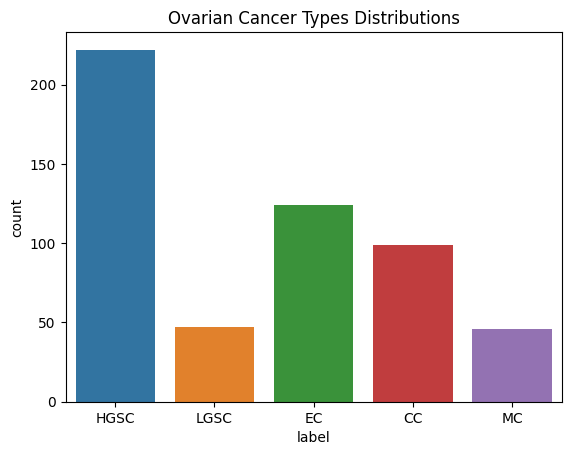

In [48]:
# To generate a histogram of the distribution of the different labels
sns.countplot(data=train_df, x="label")
plt.title("Ovarian Cancer Types Distributions")
plt.show()

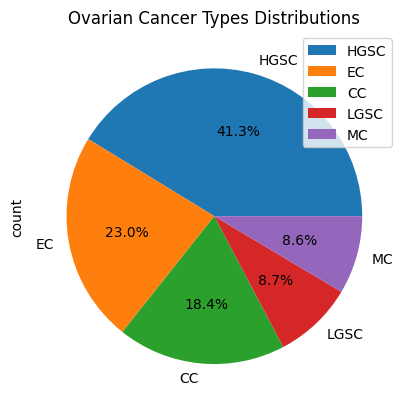

In [49]:
# To generate a pie chart of the distribution of the different labels
train_df['label'].value_counts().plot(kind='pie',autopct="%.1f%%")
plt.title("Ovarian Cancer Types Distributions")
plt.legend()
plt.show()

In [50]:
train_df.head()

image_id label  image_width  image_height  is_tma
0         4  HGSC        23785         20008   False
1        66  LGSC        48871         48195   False
2        91  HGSC         3388          3388    True
3       281  LGSC        42309         15545   False
4       286    EC        37204         30020   False

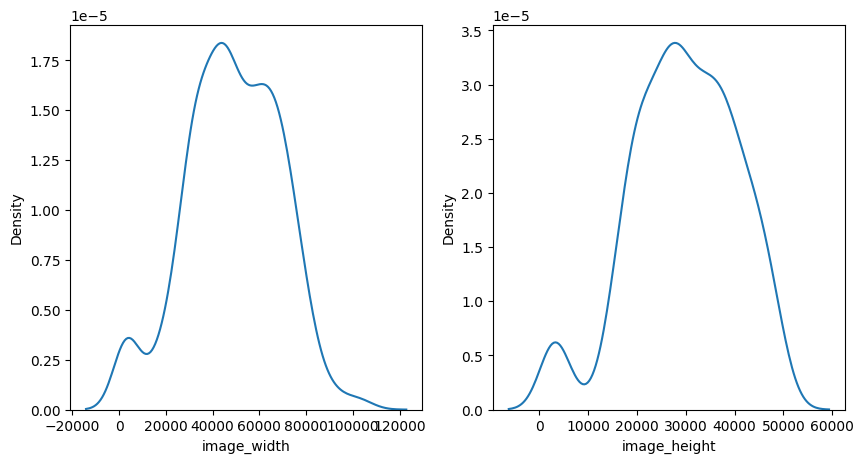

In [51]:
# To generate graphs of the distributions of the image widths and heights
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.kdeplot(train_df['image_width'])
plt.subplot(1,2,2)
sns.kdeplot(train_df['image_height'])
plt.show()

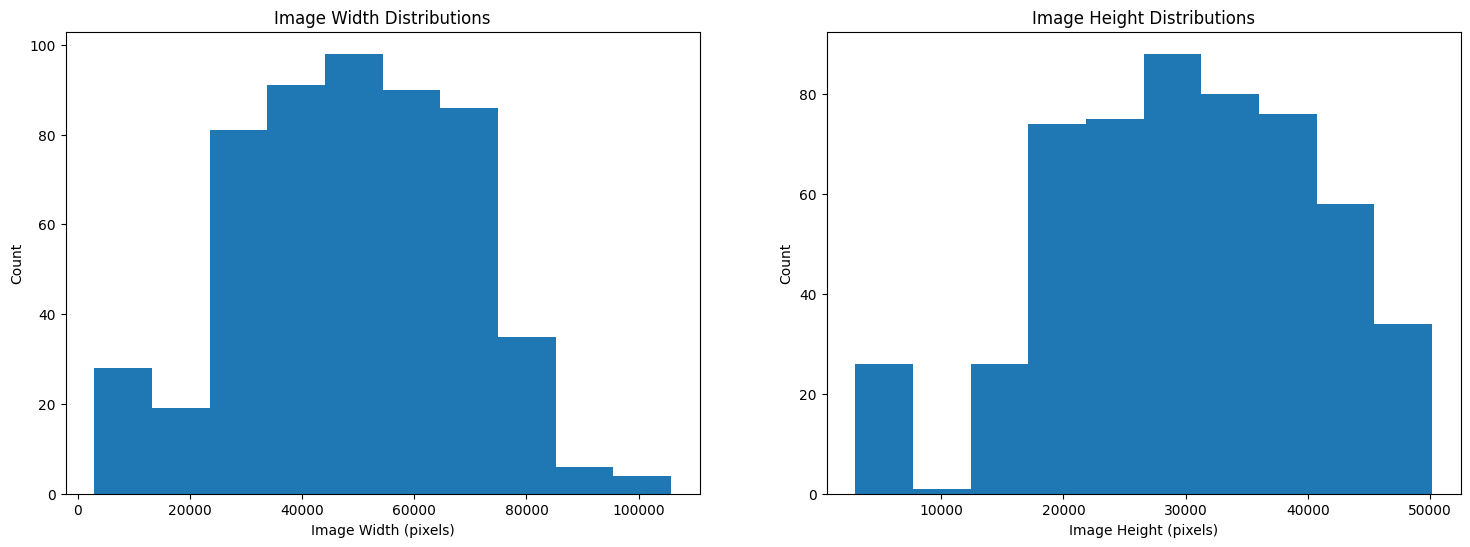

In [52]:
# To generate histograms of the distributions of the image widths and heights
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.hist(x=train_df['image_width'])
plt.title("Image Width Distributions")
plt.xlabel("Image Width (pixels)")
plt.ylabel("Count")
plt.subplot(1,2,2)
plt.hist(x=train_df['image_height'])
plt.title("Image Height Distributions")
plt.xlabel("Image Height (pixels)")
plt.ylabel("Count")
plt.show()

In [53]:
train_df['image_width'].describe()

count       538.000000
mean      48859.533457
std       20040.989927
min        2964.000000
25%       34509.000000
50%       48160.000000
75%       64143.750000
max      105763.000000
Name: image_width, dtype: float64

In [54]:
train_df['image_height'].describe()

count      538.000000
mean     29729.460967
std      10762.899796
min       2964.000000
25%      22089.500000
50%      29732.000000
75%      37880.750000
max      50155.000000
Name: image_height, dtype: float64

In [55]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538 entries, 0 to 537
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_id      538 non-null    int64 
 1   label         538 non-null    object
 2   image_width   538 non-null    int64 
 3   image_height  538 non-null    int64 
 4   is_tma        538 non-null    bool  
dtypes: bool(1), int64(3), object(1)
memory usage: 17.5+ KB


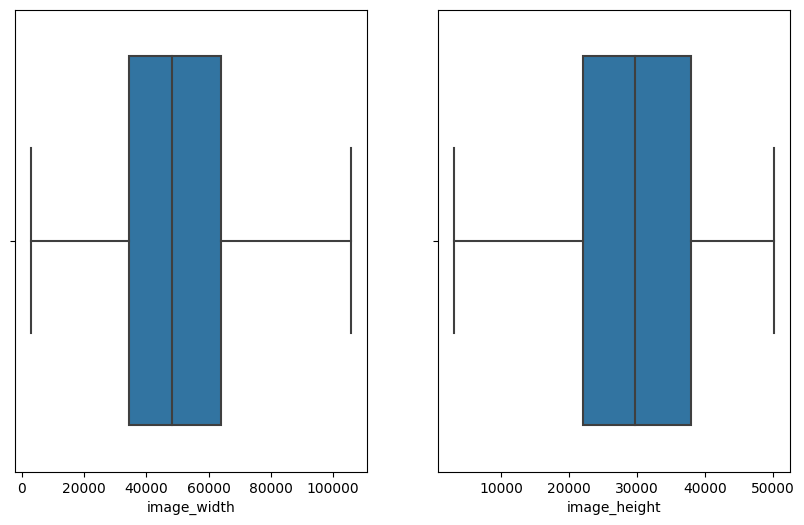

In [56]:
# To generate more visualizations of the distributions of the image widths and heights
plt.figure(figsize=(10,6)) 
plt.subplot(1,2,1)
sns.boxplot(data=train_df,x="image_width")
plt.subplot(1,2,2)
sns.boxplot(data=train_df,x="image_height")
plt.show()

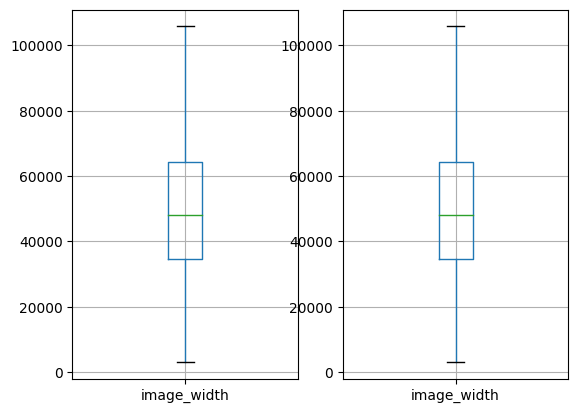

In [57]:
# To generate more visualizations of the distributions of the image widths and heights
plt.subplot(1,2,1)
train_df[['image_width']].boxplot()
plt.subplot(1,2,2)
train_df[['image_width']].boxplot()
plt.show()

In [58]:
# The paths for the medical images in the Kaggle notebook
path_train = "/kaggle/input/UBC-OCEAN/train_images"
path_test = "/kaggle/input/UBC-OCEAN/test_images"
train_folder = os.listdir(path_train)
test_folder = os.listdir(path_test)

print(len(train_folder))
print(len(test_folder))

538
1


In [59]:
train_folder[:5]

['14127.png', '34649.png', '15221.png', '52375.png', '17487.png']

In [60]:
test_folder

['41.png']

In [61]:
# The paths for the thumbnail images in the Kaggle notebook
path_train_copy = "/kaggle/input/UBC-OCEAN/train_thumbnails"
path_test_copy = "/kaggle/input/UBC-OCEAN/test_thumbnails"
train_folder_copy = os.listdir(path_train_copy)
test_folder_copy = os.listdir(path_test_copy)

print(len(train_folder_copy))
print(len(test_folder_copy))

513
1


In [62]:
train_df

image_id label  image_width  image_height  is_tma
0           4  HGSC        23785         20008   False
1          66  LGSC        48871         48195   False
2          91  HGSC         3388          3388    True
3         281  LGSC        42309         15545   False
4         286    EC        37204         30020   False
..        ...   ...          ...           ...     ...
533     65022  LGSC        53355         46675   False
534     65094    MC        55042         45080   False
535     65300  HGSC        75860         27503   False
536     65371  HGSC        42551         41800   False
537     65533  HGSC        45190         33980   False

[538 rows x 5 columns]

In [63]:
train_df['is_tma'].value_counts()

is_tma
False    513
True      25
Name: count, dtype: int64

In [64]:
# To get all of the TMA images
train_df_tma = train_df[train_df['is_tma']==True]

In [65]:
train_df_tma

image_id label  image_width  image_height  is_tma
2          91  HGSC         3388          3388    True
37       4134    MC         2964          2964    True
76       8280  HGSC         2964          2964    True
83       9200    MC         3388          3388    True
112     13568  LGSC         2964          2964    True
149     17637  HGSC         2964          2964    True
176     21020    MC         3388          3388    True
236     29084  LGSC         3388          3388    True
263     31594    EC         3388          3388    True
288     35565    MC         2964          2964    True
299     36302    CC         3388          3388    True
302     36583  LGSC         3388          3388    True
305     36783    MC         2964          2964    True
309     37385  LGSC         3388          3388    True
350     40864  LGSC         2964          2964    True
354     41368    EC         3388          3388    True
355     41586    CC         2964          2964    True
361     42857    CC         2964          2964    True
375     44603    CC         3388          3388    True
399     47035    EC         2964          2964    True
409     48734    EC         3388          3388    True
423     50932  HGSC         2964          2964    True
452     53655    EC         3388          3388    True
484     57696    CC         3388          3388    True
510     61797  HGSC         3388          3388    True

In [66]:
# To get all of the non-TMA images
train_df_no_tma = train_df[train_df['is_tma']==False]
train_df_no_tma

image_id label  image_width  image_height  is_tma
0           4  HGSC        23785         20008   False
1          66  LGSC        48871         48195   False
3         281  LGSC        42309         15545   False
4         286    EC        37204         30020   False
5         431  HGSC        39991         40943   False
..        ...   ...          ...           ...     ...
533     65022  LGSC        53355         46675   False
534     65094    MC        55042         45080   False
535     65300  HGSC        75860         27503   False
536     65371  HGSC        42551         41800   False
537     65533  HGSC        45190         33980   False

[513 rows x 5 columns]

In [67]:
train_df_no_tma['image_id_path'] = [f"{i}_thumbnail.png" for i in train_df_no_tma['image_id']]

In [68]:
train_df_no_tma

image_id label  image_width  image_height  is_tma        image_id_path
0           4  HGSC        23785         20008   False      4_thumbnail.png
1          66  LGSC        48871         48195   False     66_thumbnail.png
3         281  LGSC        42309         15545   False    281_thumbnail.png
4         286    EC        37204         30020   False    286_thumbnail.png
5         431  HGSC        39991         40943   False    431_thumbnail.png
..        ...   ...          ...           ...     ...                  ...
533     65022  LGSC        53355         46675   False  65022_thumbnail.png
534     65094    MC        55042         45080   False  65094_thumbnail.png
535     65300  HGSC        75860         27503   False  65300_thumbnail.png
536     65371  HGSC        42551         41800   False  65371_thumbnail.png
537     65533  HGSC        45190         33980   False  65533_thumbnail.png

[513 rows x 6 columns]

In [69]:
train_df_tma['image_id_path'] = [f"{i}.png" for i in train_df_tma['image_id']]

In [70]:
train_df_tma

image_id label  image_width  image_height  is_tma image_id_path
2          91  HGSC         3388          3388    True        91.png
37       4134    MC         2964          2964    True      4134.png
76       8280  HGSC         2964          2964    True      8280.png
83       9200    MC         3388          3388    True      9200.png
112     13568  LGSC         2964          2964    True     13568.png
149     17637  HGSC         2964          2964    True     17637.png
176     21020    MC         3388          3388    True     21020.png
236     29084  LGSC         3388          3388    True     29084.png
263     31594    EC         3388          3388    True     31594.png
288     35565    MC         2964          2964    True     35565.png
299     36302    CC         3388          3388    True     36302.png
302     36583  LGSC         3388          3388    True     36583.png
305     36783    MC         2964          2964    True     36783.png
309     37385  LGSC         3388          3388    True     37385.png
350     40864  LGSC         2964          2964    True     40864.png
354     41368    EC         3388          3388    True     41368.png
355     41586    CC         2964          2964    True     41586.png
361     42857    CC         2964          2964    True     42857.png
375     44603    CC         3388          3388    True     44603.png
399     47035    EC         2964          2964    True     47035.png
409     48734    EC         3388          3388    True     48734.png
423     50932  HGSC         2964          2964    True     50932.png
452     53655    EC         3388          3388    True     53655.png
484     57696    CC         3388          3388    True     57696.png
510     61797  HGSC         3388          3388    True     61797.png

In [71]:
train_thumbnails_folder = train_folder_copy

In [72]:
train_thumbnails_folder[:5]

['52275_thumbnail.png',
 '47960_thumbnail.png',
 '4_thumbnail.png',
 '57468_thumbnail.png',
 '20316_thumbnail.png']

In [73]:
train_folder[:5]

['14127.png', '34649.png', '15221.png', '52375.png', '17487.png']

In [74]:
train_df.head()

image_id label  image_width  image_height  is_tma
0         4  HGSC        23785         20008   False
1        66  LGSC        48871         48195   False
2        91  HGSC         3388          3388    True
3       281  LGSC        42309         15545   False
4       286    EC        37204         30020   False

In [75]:
train_thumbnails_folder[:5]

['52275_thumbnail.png',
 '47960_thumbnail.png',
 '4_thumbnail.png',
 '57468_thumbnail.png',
 '20316_thumbnail.png']

In [76]:
train_folder[:5]

['14127.png', '34649.png', '15221.png', '52375.png', '17487.png']

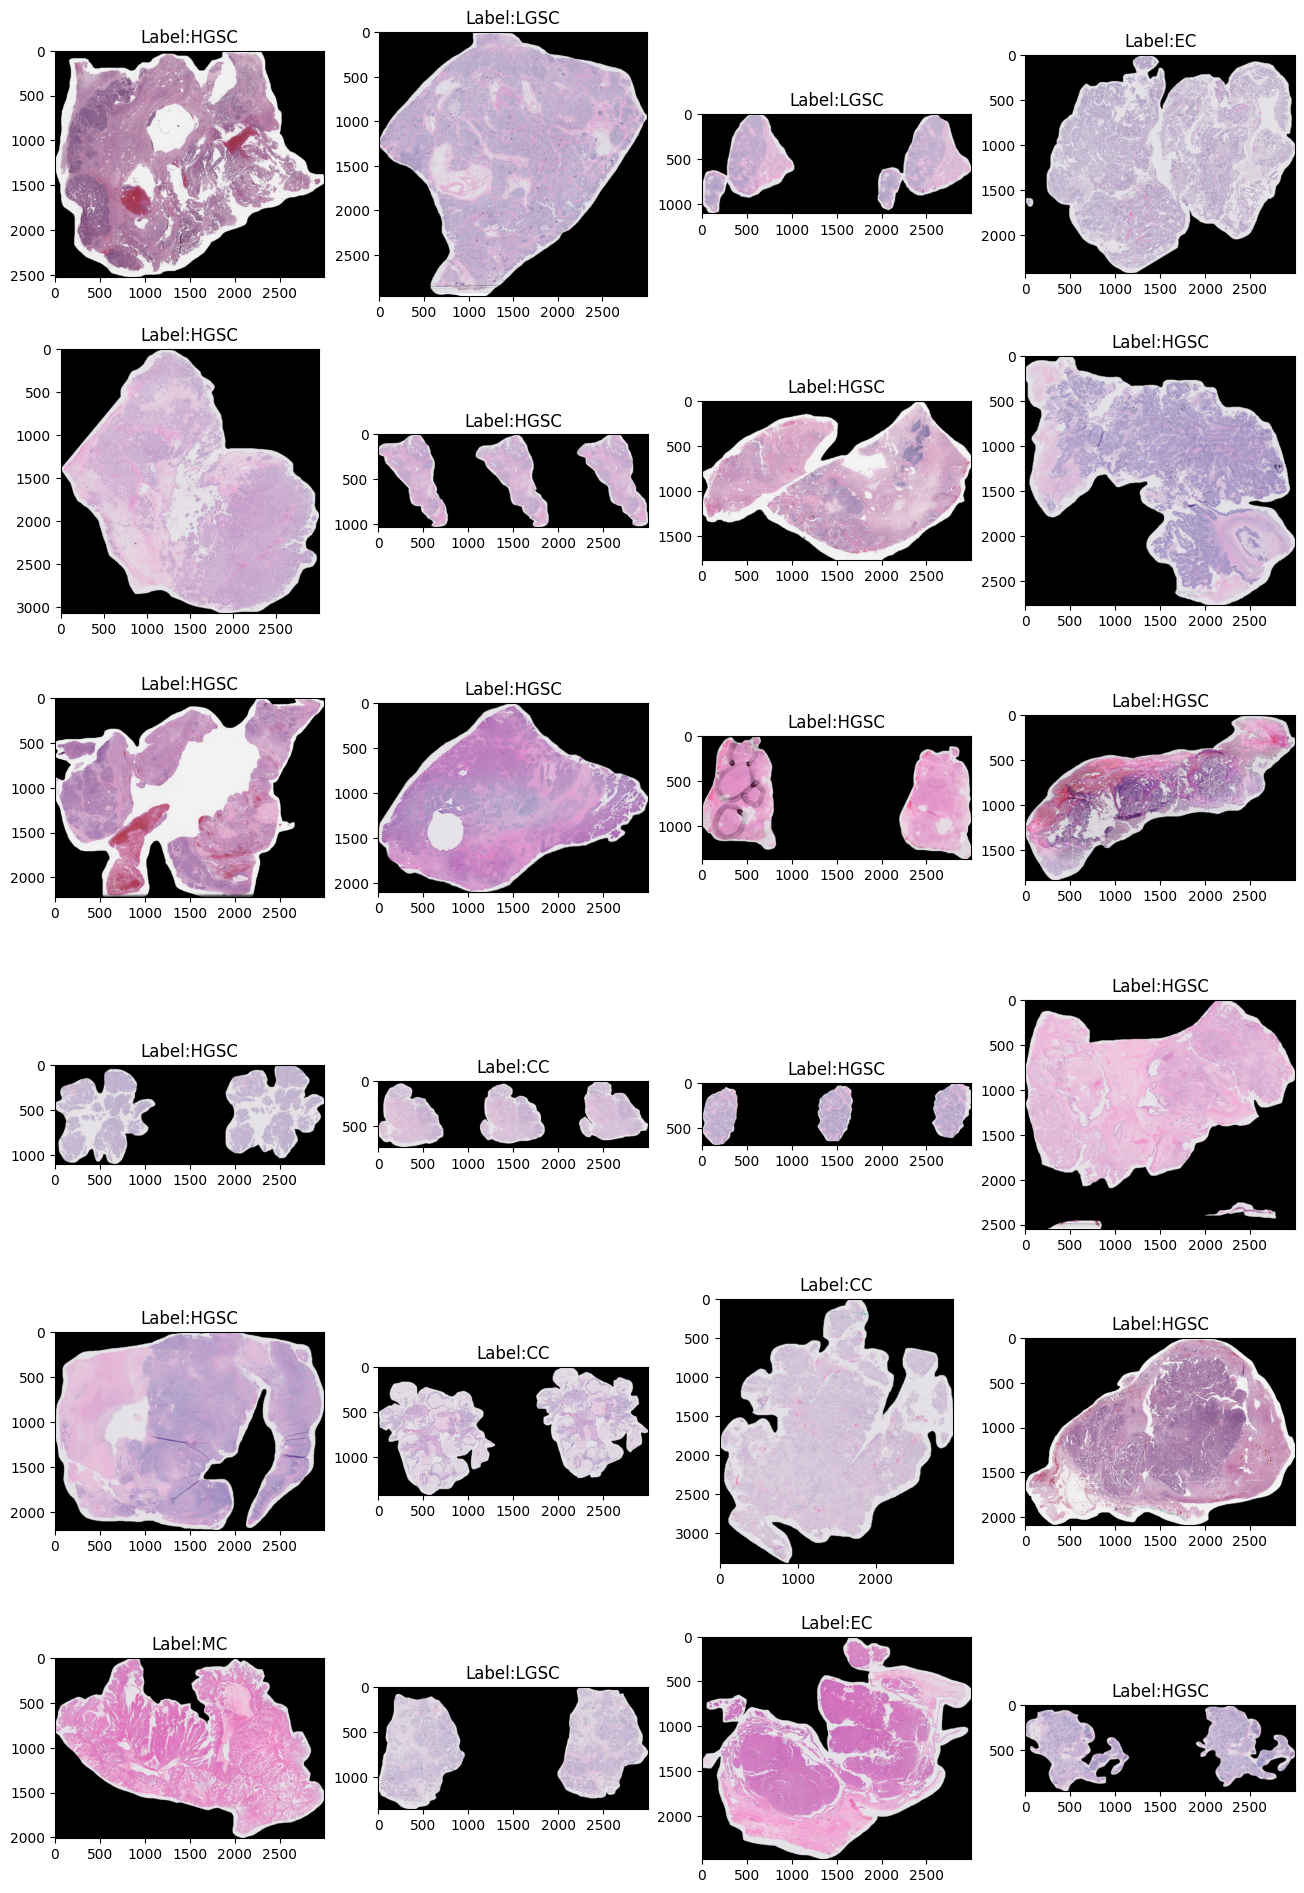

In [77]:
# Visualizing some of the thumbnail images
plt.figure(figsize=(16,24))
path = "/kaggle/input/UBC-OCEAN/train_thumbnails"
j=1
for img, lb in zip(train_df_no_tma['image_id_path'][:24],train_df_no_tma['label'][:24]):
    plt.subplot(6,4,j)
    path = os.path.join("/kaggle/input/UBC-OCEAN/train_thumbnails/",img)
    image = plt.imread(path)
    image = plt.imshow(image)
    plt.title(f"Label:{lb}")
    j+=1

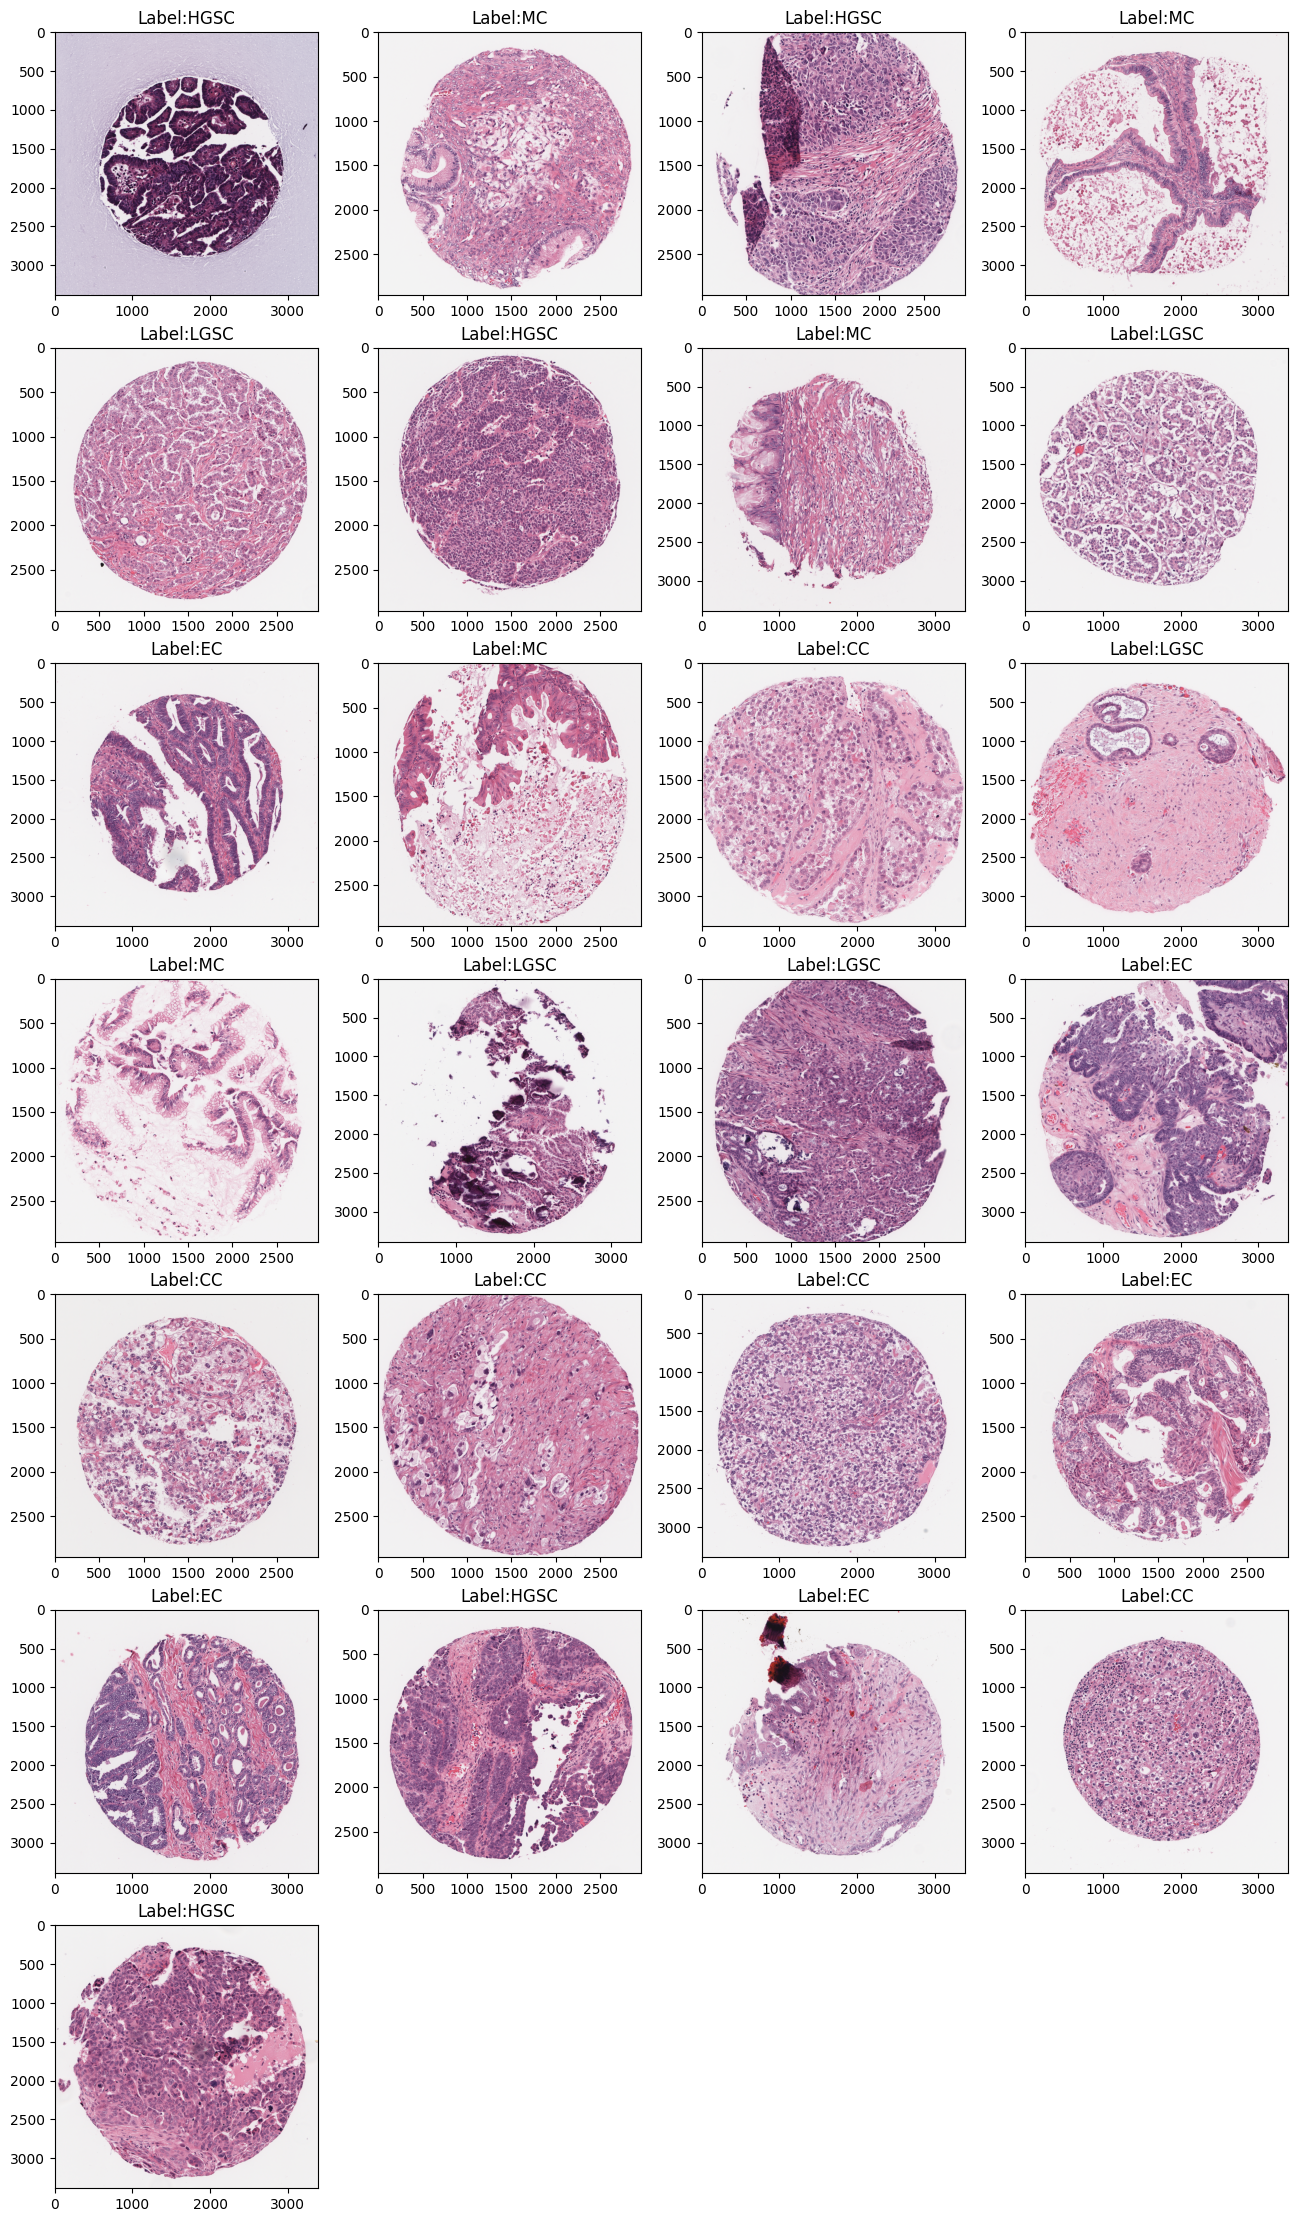

In [78]:
# Visualizing some of the medical images
plt.figure(figsize=(16,28))
path = "/kaggle/input/UBC-OCEAN/train_images"
j=1
for img, lb in zip(train_df_tma['image_id_path'],train_df_tma['label']):
    plt.subplot(7,4,j)
    path = os.path.join("/kaggle/input/UBC-OCEAN/train_images",img)
    image = plt.imread(path)
    image = plt.imshow(image)
    plt.title(f"Label:{lb}")
    j+=1

In [79]:
# Printing some statistics about the dataset
print(train_df['image_width'].min())
print(train_df['image_width'].max())
print(train_df['image_width'].mean())
print()
print(train_df['image_height'].min())
print(train_df['image_height'].max())
print(train_df['image_height'].mean())

2964
105763
48859.53345724907

2964
50155
29729.460966542752
